In [ ]:
!wget https://perso.esiee.fr/~gueurett/LV_Research/WS_analysis_results_14.csv

--2022-07-19 22:04:01--  https://perso.esiee.fr/~gueurett/LV_Research/WS_analysis_results.csv
Resolving perso.esiee.fr (perso.esiee.fr)... 147.215.150.8
Connecting to perso.esiee.fr (perso.esiee.fr)|147.215.150.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 958567 (936K) [text/csv]
Saving to: ‘WS_analysis_results.csv’

WS_analysis_results 100%[===================>] 936.10K  1.86MB/s    in 0.5s    

2022-07-19 22:04:02 (1.86 MB/s) - ‘WS_analysis_results.csv’ saved [958567/958567]



In [ ]:
!wget https://perso.esiee.fr/~gueurett/LV_Research/Acoustic_Analysis_Results.csv

--2022-07-19 22:04:04--  https://perso.esiee.fr/~gueurett/LV_Research/Acoustic_Analysis_Results.csv
Resolving perso.esiee.fr (perso.esiee.fr)... 147.215.150.8
Connecting to perso.esiee.fr (perso.esiee.fr)|147.215.150.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68157 (67K) [text/csv]
Saving to: ‘Acoustic_Analysis_Results.csv’

Acoustic_Analysis_R 100%[===================>]  66.56K   408KB/s    in 0.2s    

2022-07-19 22:04:05 (408 KB/s) - ‘Acoustic_Analysis_Results.csv’ saved [68157/68157]



In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import preprocessing
from keras import layers, initializers
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.ensemble import RandomForestClassifier

In [ ]:
prints = False

data = pd.read_csv('WS_analysis_results_14.csv', delimiter=',', dtype=None, encoding=None)
data = data.rename(columns={'MOMENTS': 'Filename'}) # rename the MOMENTS column to the filename column

data_2 = pd.read_csv('Acoustic_Analysis_Results.csv', delimiter=',', dtype=None, encoding=None)
data_2 = data_2.rename(columns={'Unnamed: 0': 'Filename'}) # rename the not-named column to the filename column
data_2 = data_2.fillna(data_2.mean(numeric_only=True))

n_samples = 200
n_windows = 14
n_features = 35

dataset = np.ones(shape=(n_samples * n_windows, n_features))
dataset_incr = np.ones(shape=(n_samples * (n_windows+1), n_features))
labels  = np.zeros(shape=(n_samples * n_windows))
labels_incr = np.zeros(shape=(n_samples * (n_windows+1)))

for column_name in data.columns:
  if column_name == 'Filename': continue
  data[column_name] = (data[column_name] - np.mean(data[column_name])) / np.std(data[column_name])

for column_name in data_2.columns:
  if column_name == 'Filename': continue
  data_2[column_name] = (data_2[column_name] - np.mean(data_2[column_name])) / np.std(data_2[column_name])


for index, row in data.iterrows():

  filename = row['Filename'][:-4]
  if prints: print("filename without wav: ", filename)

  label, n_sample, n_part = filename.split('_')
  n_sample = int(n_sample)
  n_part   = int(n_part)

  if prints:
    print("label: ", label)
    print("n_sample: ", n_sample)
    print("n_part: ", n_part)

  if label == 'I':
    labels[index] = 1
    labels_incr[index] = 1

  row = data.iloc[index].to_numpy()[1:]
  if prints:
    print("row.shape: ", row.shape)
    print("dataset.shape:  ", dataset.shape)
    print("dataset[n_sample, n_part, :].shape:  ", dataset[n_sample, n_part, :].shape, '\n\n')
  dataset[index, :] = row
  dataset_incr[index, :] = row

index += 1
for index_data_2, row in data_2.iterrows():

  label = row['Filename'][0]
  if label == 'I':
    labels_incr[index + index_data_2] = 1

data_2 = data_2.drop(columns=['Filename'])
data_2 = data_2.to_numpy()

for index_data_2, features in enumerate(data_2):
  dataset_incr[index + index_data_2] = features

rng     = np.random.default_rng() # shuffle time
shuffle = rng.choice(n_samples*n_windows, size=(n_samples * n_windows), replace=False)
data    = dataset[shuffle]
labels  = labels[shuffle]

shuffle_incr = rng.choice(n_samples*(n_windows+1), size=(n_samples * (n_windows+1)), replace=False)
data_incr    = dataset_incr[shuffle_incr]
labels_incr  = labels_incr[shuffle_incr]

print("---------------------------------")
print("|  data.shape:   ", data.shape, "   |")
print("|  labels.shape: ", labels.shape, "      |")
print("---------------------------------")
print("---------------------------------")
print("|  data_incr.shape:", data_incr.shape, " |")
print("|  labels.shape:   ", labels_incr.shape, "    |")
print("---------------------------------")

---------------------------------
|  data.shape:    (2800, 35)    |
|  labels.shape:  (2800,)       |
---------------------------------
---------------------------------
|  data_incr.shape: (3000, 35)  |
|  labels.shape:    (3000,)     |
---------------------------------


In [ ]:
def plot_things(history):
  fig = plt.figure(figsize=(10, 8))
  plt.subplot(2,1,1)
  plt.plot(history.history['binary_accuracy'])
  plt.plot(history.history['val_binary_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  fig = plt.figure(figsize=(10, 8))
  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [ ]:
def get_model(dropout_rate=0.3, nb_neurons=20):

  model = tf.keras.Sequential()

  model.add(layers.Dense(nb_neurons, input_shape=(n_features,)))
  model.add(layers.ReLU())
  model.add(layers.Dropout(dropout_rate))

  model.add(layers.Dense(1, activation='sigmoid'))

  optimizer = Adam(0.001, beta_1=0.1)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

  return model

In [ ]:
model = get_model()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

history = model.fit(data, labels, epochs=100, validation_split=0.3, callbacks=[callback])

Epoch 1/100
62/62 [==============================] - 1s 6ms/step - loss: 0.6474 - binary_accuracy: 0.6789 - val_loss: 0.5935 - val_binary_accuracy: 0.6885
Epoch 2/100
62/62 [==============================] - 0s 4ms/step - loss: 0.5661 - binary_accuracy: 0.7254 - val_loss: 0.5622 - val_binary_accuracy: 0.6944
Epoch 3/100
62/62 [==============================] - 0s 4ms/step - loss: 0.5300 - binary_accuracy: 0.7320 - val_loss: 0.5472 - val_binary_accuracy: 0.7051
Epoch 4/100
62/62 [==============================] - 0s 3ms/step - loss: 0.5155 - binary_accuracy: 0.7463 - val_loss: 0.5356 - val_binary_accuracy: 0.7182
Epoch 5/100
62/62 [==============================] - 0s 3ms/step - loss: 0.4965 - binary_accuracy: 0.7611 - val_loss: 0.5286 - val_binary_accuracy: 0.7241
Epoch 6/100
62/62 [==============================] - 0s 3ms/step - loss: 0.4739 - binary_accuracy: 0.7703 - val_loss: 0.5219 - val_binary_accuracy: 0.7277
Epoch 7/100
62/62 [==============================] - 0s 3ms/step - los

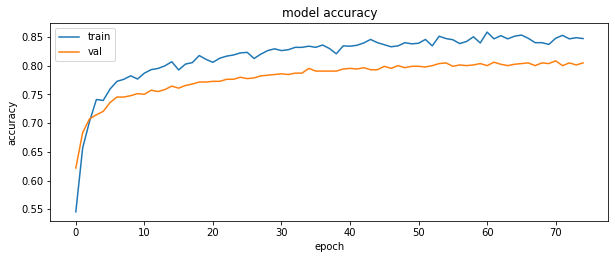

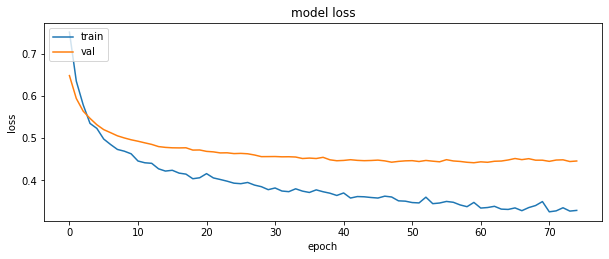

In [ ]:
plot_things(history)

In [ ]:
number_splits = 8
number_runs   = 5
results_acc   = np.zeros(shape=(number_runs, number_splits))
results_loss  = np.zeros(shape=(number_runs, number_splits))


for run in range(number_runs):
  
  print("\n\n\nDoing the run number ", run+1)
  kfold = KFold(n_splits=number_splits, shuffle=True)

  # K-fold Cross Validation model evaluation
  fold_no = 1

  for split,(fold_train, fold_test) in enumerate(kfold.split(data, labels)):

    model = get_model()
    print("Training the fold number ", fold_no,"\n")
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
    history = model.fit(data[fold_train], labels[fold_train], epochs=75, callbacks=[callback])

    scores = model.evaluate(data[fold_test], labels[fold_test], verbose=0)
    print("For the fold number ",  fold_no, ":\nloss = ", scores[0], "\naccuracy = ", scores[1]*100,"%")
    results_acc[run][split] = scores[1] * 100
    results_loss[run][split] = scores[0]

    # Increase fold number
    fold_no = fold_no + 1


results_acc = np.mean(results_acc, axis=1)
results_loss = np.mean(results_loss, axis=1)

results_acc = np.mean(results_acc)
results_loss = np.mean(results_loss)

print("\n\n\nWe obtain the following results:\nmean accuracy: ",results_acc,"%", "\nmean loss:",results_loss)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
77/77 [==============================] - 0s 3ms/step - loss: 0.3827 - binary_accuracy: 0.8331
Epoch 30/75
77/77 [==============================] - 0s 2ms/step - loss: 0.3738 - binary_accuracy: 0.8339
Epoch 31/75
77/77 [==============================] - 0s 2ms/step - loss: 0.3768 - binary_accuracy: 0.8298
Epoch 32/75
77/77 [==============================] - 0s 2ms/step - loss: 0.3740 - binary_accuracy: 0.8241
Epoch 33/75
77/77 [==============================] - 0s 2ms/step - loss: 0.3721 - binary_accuracy: 0.8249
Epoch 34/75
77/77 [==============================] - 0s 2ms/step - loss: 0.3652 - binary_accuracy: 0.8408
Epoch 35/75
77/77 [==============================] - 0s 2ms/step - loss: 0.3661 - binary_accuracy: 0.8269
Epoch 36/75
77/77 [==============================] - 0s 3ms/step - loss: 0.3623 - binary_accuracy: 0.8318
Epoch 37/75
77/77 [==============================] - 0s 2ms/step - loss: 0.3570 - bina

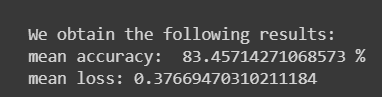

---
---
# **Data_incr**

In [ ]:
def get_model_incr(dropout_rate=0.3, nb_neurons=30):

  model = tf.keras.Sequential()

  model.add(layers.Dense(nb_neurons, input_shape=(n_features,)))
  model.add(layers.ReLU())
  model.add(layers.Dropout(dropout_rate))

  model.add(layers.Dense(1, activation='sigmoid'))

  optimizer = Adam(0.001, beta_1=0.1)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

  return model

In [ ]:
model = get_model_incr()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

history = model.fit(data_incr, labels_incr, epochs=200, validation_split=0.3, callbacks=[callback])

Epoch 1/200
66/66 [==============================] - 2s 10ms/step - loss: 0.6754 - binary_accuracy: 0.6381 - val_loss: 0.5764 - val_binary_accuracy: 0.7222
Epoch 2/200
66/66 [==============================] - 0s 4ms/step - loss: 0.5703 - binary_accuracy: 0.7200 - val_loss: 0.5309 - val_binary_accuracy: 0.7411
Epoch 3/200
66/66 [==============================] - 0s 3ms/step - loss: 0.5268 - binary_accuracy: 0.7395 - val_loss: 0.5044 - val_binary_accuracy: 0.7633
Epoch 4/200
66/66 [==============================] - 0s 3ms/step - loss: 0.5061 - binary_accuracy: 0.7543 - val_loss: 0.4861 - val_binary_accuracy: 0.7711
Epoch 5/200
66/66 [==============================] - 0s 3ms/step - loss: 0.4887 - binary_accuracy: 0.7562 - val_loss: 0.4728 - val_binary_accuracy: 0.7778
Epoch 6/200
66/66 [==============================] - 0s 4ms/step - loss: 0.4715 - binary_accuracy: 0.7624 - val_loss: 0.4619 - val_binary_accuracy: 0.7811
Epoch 7/200
66/66 [==============================] - 0s 4ms/step - lo

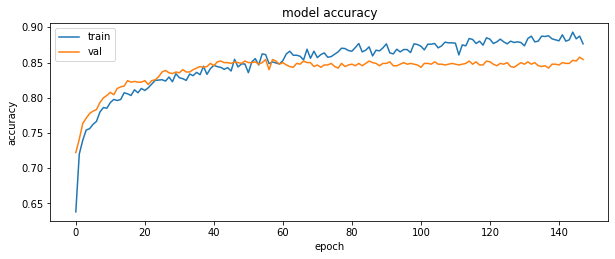

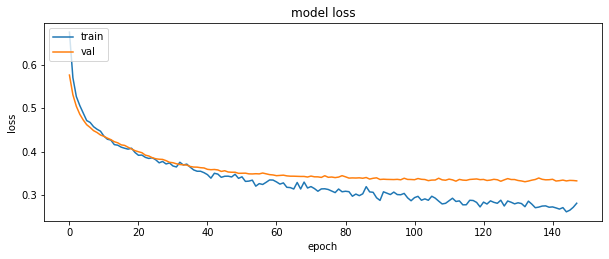

In [ ]:
plot_things(history)

In [ ]:
number_splits = 8
number_runs   = 5
results_acc   = np.zeros(shape=(number_runs, number_splits))
results_loss  = np.zeros(shape=(number_runs, number_splits))


for run in range(number_runs):
  
  print("\n\n\nDoing the run number ", run+1)
  kfold = KFold(n_splits=number_splits, shuffle=True)

  # K-fold Cross Validation model evaluation
  fold_no = 1

  for split,(fold_train, fold_test) in enumerate(kfold.split(data_incr, labels_incr)):

    model = get_model()
    print("Training the fold number ", fold_no,"\n")
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
    history = model.fit(data_incr[fold_train], labels_incr[fold_train], epochs=160, callbacks=[callback])

    scores = model.evaluate(data_incr[fold_test], labels_incr[fold_test], verbose=0)
    print("For the fold number ",  fold_no, ":\nloss = ", scores[0], "\naccuracy = ", scores[1]*100,"%")
    results_acc[run][split] = scores[1] * 100
    results_loss[run][split] = scores[0]

    # Increase fold number
    fold_no = fold_no + 1


results_acc = np.mean(results_acc, axis=1)
results_loss = np.mean(results_loss, axis=1)

results_acc = np.mean(results_acc)
results_loss = np.mean(results_loss)

print("\n\n\nWe obtain the following results:\nmean accuracy: ",results_acc,"%", "\nmean loss:",results_loss)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
83/83 [==============================] - 0s 3ms/step - loss: 0.3815 - binary_accuracy: 0.8324
Epoch 36/160
83/83 [==============================] - 0s 3ms/step - loss: 0.3836 - binary_accuracy: 0.8305
Epoch 37/160
83/83 [==============================] - 0s 3ms/step - loss: 0.3778 - binary_accuracy: 0.8259
Epoch 38/160
83/83 [==============================] - 0s 2ms/step - loss: 0.3750 - binary_accuracy: 0.8293
Epoch 39/160
83/83 [==============================] - 0s 3ms/step - loss: 0.3690 - binary_accuracy: 0.8320
Epoch 40/160
83/83 [==============================] - 0s 3ms/step - loss: 0.3764 - binary_accuracy: 0.8282
Epoch 41/160
83/83 [==============================] - 0s 3ms/step - loss: 0.3696 - binary_accuracy: 0.8290
Epoch 42/160
83/83 [==============================] - 0s 3ms/step - loss: 0.3694 - binary_accuracy: 0.8328
Epoch 43/160
83/83 [==============================] - 0s 3ms/step - loss: 0.369

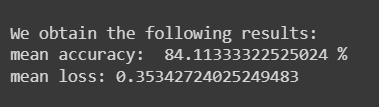